# <u>CNN Classification:</u>
#### Itay Galili



In [11]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Load CIFAR10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

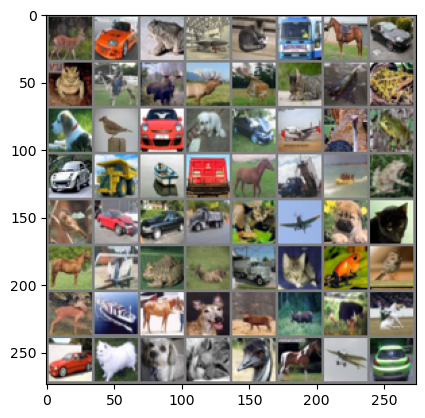

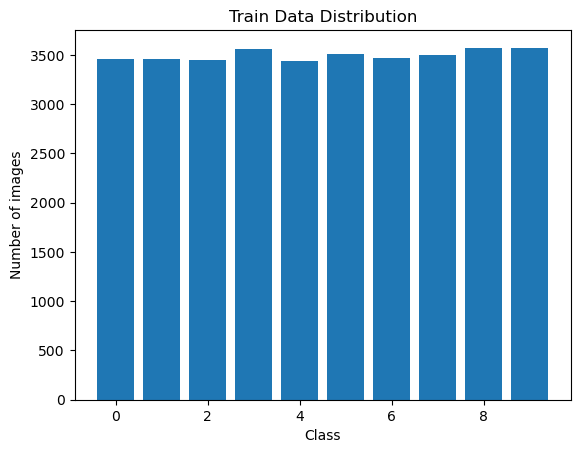

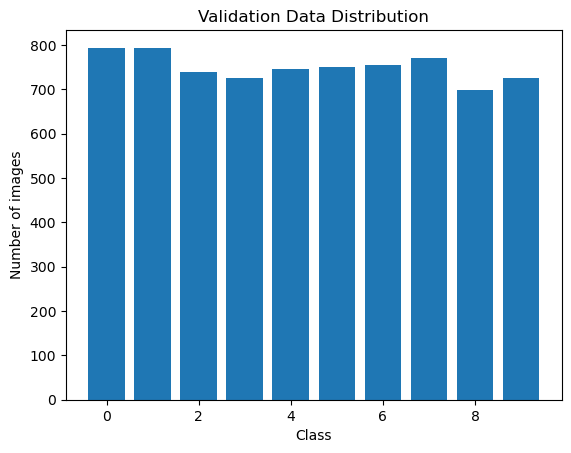

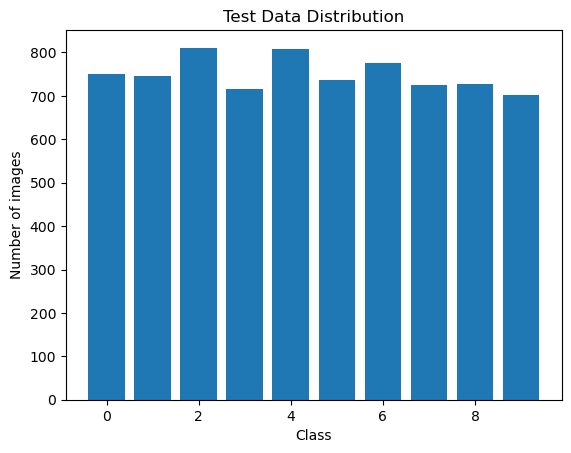

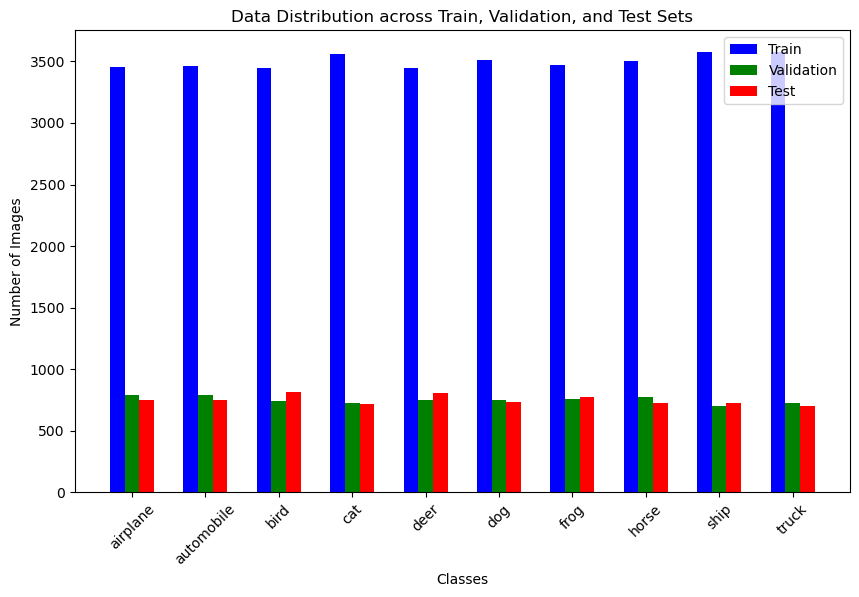

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Function to get data distribution
def get_data_distribution(loader):
    labels_count = [0] * 10
    for _, labels in loader:
        for label in labels:
            labels_count[label] += 1
    return labels_count

# Plotting combined data distribution for train, validation, and test sets
def plot_combined_distribution(train_loader, val_loader, test_loader):
    train_distribution = get_data_distribution(train_loader)
    val_distribution = get_data_distribution(val_loader)
    test_distribution = get_data_distribution(test_loader)
    
    x = np.arange(len(classes))  # Class indices
    
    # Plot the distributions
    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.2, train_distribution, width=0.2, color='b', align='center', label='Train')
    plt.bar(x, val_distribution, width=0.2, color='g', align='center', label='Validation')
    plt.bar(x + 0.2, test_distribution, width=0.2, color='r', align='center', label='Test')
    
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Data Distribution across Train, Validation, and Test Sets')
    plt.xticks(x, classes, rotation=45)
    plt.legend()
    plt.show()

# Call the function to plot the combined data distribution
plot_combined_distribution(train_loader, val_loader, test_loader)


In [12]:
len(dataset)

50000

In [1]:
# Define the CNN model
class FlexibleCNN(nn.Module):
    def __init__(self, kernel_size=3, fc_layers=[128, 64], dropout_cnn=0.2, dropout_fc=0.5):
        super(FlexibleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_cnn = nn.Dropout(dropout_cnn)

        # Fully connected layers, the input to the first FC layer is based on the output from conv layers
        fc_input_size = 64 * 8 * 8
        self.fc_layers = nn.ModuleList()
        
        # Create the fully connected layers dynamically based on the fc_layers list
        for i, layer_size in enumerate(fc_layers):
            self.fc_layers.append(nn.Linear(fc_input_size, layer_size))
            fc_input_size = layer_size
        
        # Output layer (always 10 for CIFAR10)
        self.output_layer = nn.Linear(fc_input_size, 10)
        self.dropout_fc = nn.Dropout(dropout_fc)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout_cnn(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        
        for fc in self.fc_layers:
            x = F.relu(fc(x))
            x = self.dropout_fc(x)
        
        x = self.output_layer(x)
        return x

# Training function
def train_model(train_loader, val_loader, model, criterion, optimizer, epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss_train = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            running_loss_train += loss.item()

        avg_loss_train = running_loss_train / len(train_loader)
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        running_loss_val = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item()
        
        avg_loss_val = running_loss_val / len(val_loader)
        
        # Store losses for plotting
        train_losses.append(avg_loss_train)
        val_losses.append(avg_loss_val)

        if (epoch + 1) % 5 == 0:  # Print every 5 epochs
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss_train:.4f}, Val Loss: {avg_loss_val:.4f}")

    # Plot losses
    plt.figure(figsize=(10,5))
    plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch [5/25], Train Loss: 1.3008, Val Loss: 1.2906
Epoch [10/25], Train Loss: 1.0819, Val Loss: 1.1440
Epoch [15/25], Train Loss: 0.9555, Val Loss: 1.0630
Epoch [20/25], Train Loss: 0.8672, Val Loss: 0.9720
Epoch [25/25], Train Loss: 0.7908, Val Loss: 0.9558


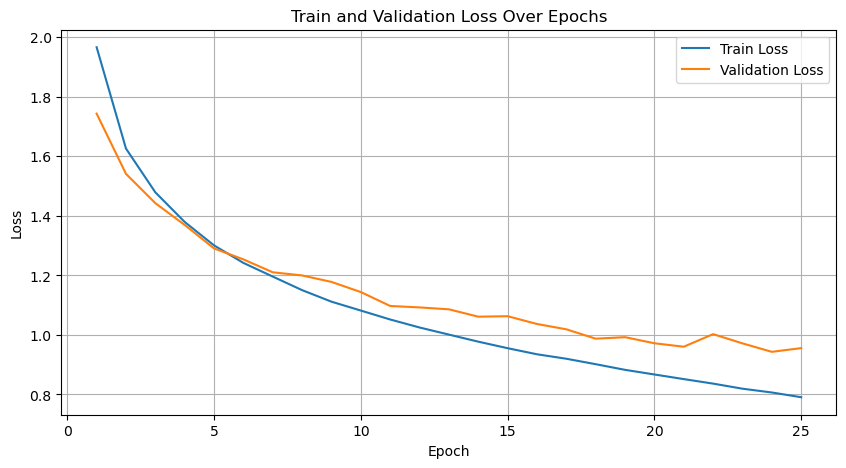

In [47]:
# Hyperparameters
learning_rate = 0.01
epochs = 25
weight_decay = 0.0001
dropout_cnn = 0.0
dropout_fc = 0.0
kernel_size = 3  # Change kernel size here
fc_layers = []  # Define the size of the fully connected layers here

# Initialize model, criterion, and optimizer
model = FlexibleCNN(kernel_size=kernel_size, fc_layers=fc_layers, dropout_cnn=dropout_cnn, dropout_fc=dropout_fc)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Use the function with the provided data loaders and hyperparameters
train_model(train_loader, val_loader, model, criterion, optimizer, epochs)


Epoch [5/25], Train Loss: 1.3767, Val Loss: 1.3614
Epoch [10/25], Train Loss: 1.2232, Val Loss: 1.2350
Epoch [15/25], Train Loss: 1.1095, Val Loss: 1.1410
Epoch [20/25], Train Loss: 1.0216, Val Loss: 1.0251
Epoch [25/25], Train Loss: 0.9584, Val Loss: 1.0137


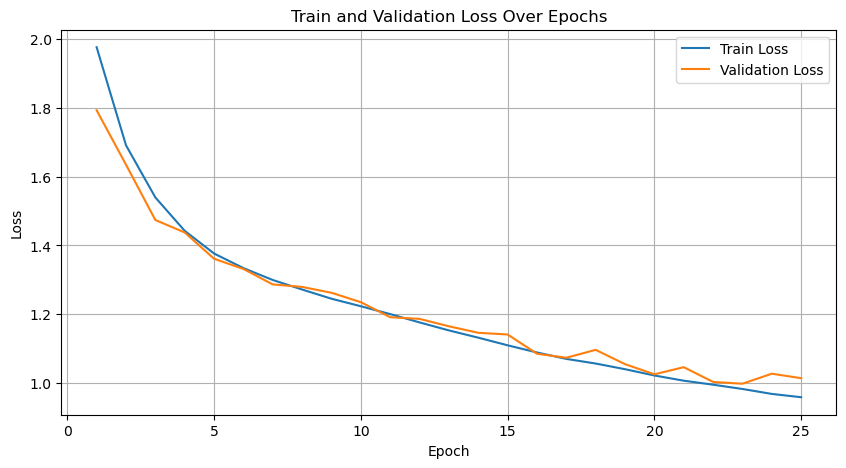

In [48]:
# Hyperparameters
learning_rate = 0.01
epochs = 25
weight_decay = 0.0001
dropout_cnn = 0.5
dropout_fc = 0.0
kernel_size = 3  # Change kernel size here
fc_layers = []  # Define the size of the fully connected layers here

# Initialize model, criterion, and optimizer
model = FlexibleCNN(kernel_size=kernel_size, fc_layers=fc_layers, dropout_cnn=dropout_cnn, dropout_fc=dropout_fc)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Use the function with the provided data loaders and hyperparameters
train_model(train_loader, val_loader, model, criterion, optimizer, epochs)


Epoch [5/25], Train Loss: 1.5051, Val Loss: 1.4593
Epoch [10/25], Train Loss: 1.2048, Val Loss: 1.2563
Epoch [15/25], Train Loss: 1.0064, Val Loss: 1.1110
Epoch [20/25], Train Loss: 0.8383, Val Loss: 0.9906
Epoch [25/25], Train Loss: 0.6812, Val Loss: 0.9225


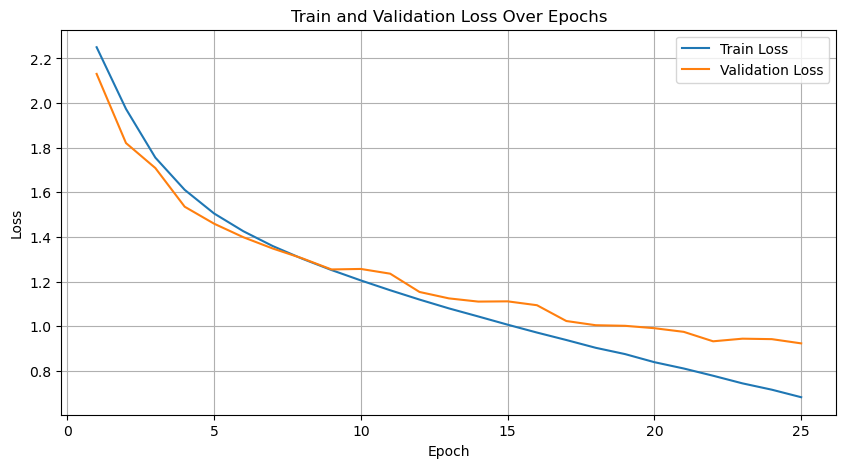

In [49]:
# Hyperparameters
learning_rate = 0.01
epochs = 25
weight_decay = 0.0001
dropout_cnn = 0.0
dropout_fc = 0.0
kernel_size = 3  # Change kernel size here
fc_layers = [128,64]  # Define the size of the fully connected layers here

# Initialize model, criterion, and optimizer
model = FlexibleCNN(kernel_size=kernel_size, fc_layers=fc_layers, dropout_cnn=dropout_cnn, dropout_fc=dropout_fc)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Use the function with the provided data loaders and hyperparameters
train_model(train_loader, val_loader, model, criterion, optimizer, epochs)


Epoch [5/25], Train Loss: 1.3238, Val Loss: 1.3472
Epoch [10/25], Train Loss: 1.1180, Val Loss: 1.1641
Epoch [15/25], Train Loss: 0.9948, Val Loss: 1.0822
Epoch [20/25], Train Loss: 0.9054, Val Loss: 1.0042
Epoch [25/25], Train Loss: 0.8305, Val Loss: 0.9891


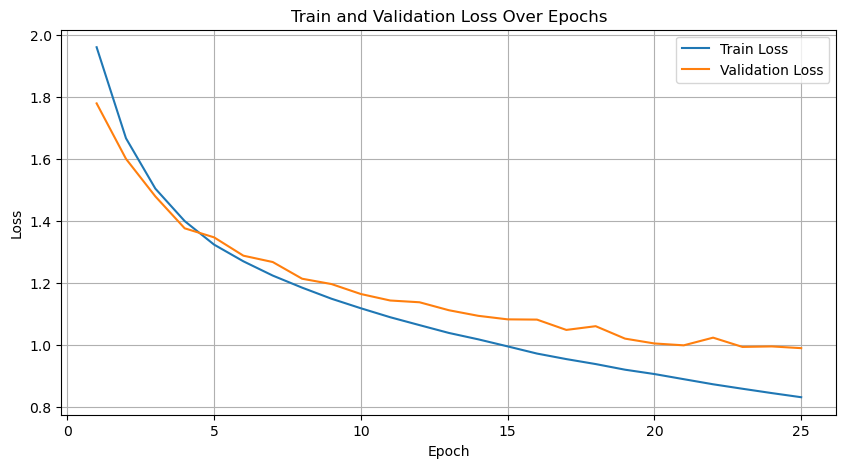

In [51]:
# Hyperparameters
learning_rate = 0.01
epochs = 25
weight_decay = 0.001
dropout_cnn = 0.0
dropout_fc = 0.0
kernel_size = 3  # Change kernel size here
fc_layers = []  # Define the size of the fully connected layers here

# Initialize model, criterion, and optimizer
model = FlexibleCNN(kernel_size=kernel_size, fc_layers=fc_layers, dropout_cnn=dropout_cnn, dropout_fc=dropout_fc)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Use the function with the provided data loaders and hyperparameters
train_model(train_loader, val_loader, model, criterion, optimizer, epochs)


In [4]:
# Define the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CNN model class definition
class CNN(nn.Module):
    def __init__(self, kernel_size, fc_neurons_list, dropout_cnn, dropout_fc):
        super(CNN, self).__init__()
        
        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=kernel_size, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, padding=1)
        
        # Flattening
        self.flatten = nn.Flatten()

        # Fully connected layers (based on fc_neurons_list)
        fc_input_size = 64 * (32 // (2*2)) * (32 // (2*2))  # Based on CIFAR-10 image size and pooling
        
        fc = []
        for neurons in fc_neurons_list:
            fc.append(nn.Linear(fc_input_size, neurons))
            fc.append(nn.ReLU())
            fc.append(nn.Dropout(dropout_fc))
            fc_input_size = neurons
        fc.append(nn.Linear(fc_input_size, 10))  # Output layer (10 classes)
        
        self.fc_layers = nn.Sequential(*fc)
        self.dropout_cnn = nn.Dropout(dropout_cnn)
    
    def forward(self, x):
        # Apply CNN layers
        x = self.pool(self.dropout_cnn(nn.ReLU()(self.conv1(x))))
        x = self.pool(self.dropout_cnn(nn.ReLU()(self.conv2(x))))
        
        # Flatten and apply FC layers
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

In [5]:
# Training function with early stopping
def train_model(model, train_loader, val_loader, lr, l2, epochs, patience):
    # Define Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    
    # Early stopping setup
    best_val_loss = np.inf
    early_stopping_counter = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation Phase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
        
        avg_val_loss = running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Print train/validation loss every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Early stopping condition
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
            # Save the best model's state
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered")
                break

    # Plot training/validation loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.show()

In [6]:
# Function to test the model and print Confusion Matrix
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Data')
    plt.show()

Epoch 5/50, Train Loss: 1.2531, Val Loss: 1.1481
Epoch 10/50, Train Loss: 1.0538, Val Loss: 1.0266
Epoch 15/50, Train Loss: 0.9379, Val Loss: 0.9271
Epoch 20/50, Train Loss: 0.8559, Val Loss: 0.8868
Epoch 25/50, Train Loss: 0.7863, Val Loss: 0.8586
Epoch 30/50, Train Loss: 0.7376, Val Loss: 0.8807
Epoch 35/50, Train Loss: 0.6919, Val Loss: 0.8336
Epoch 40/50, Train Loss: 0.6402, Val Loss: 0.8437
Epoch 45/50, Train Loss: 0.6098, Val Loss: 0.8599
Early stopping triggered


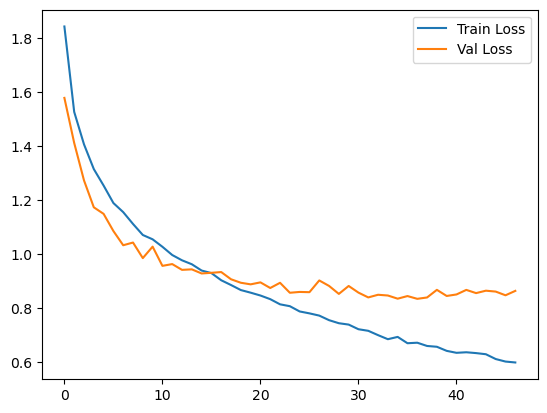

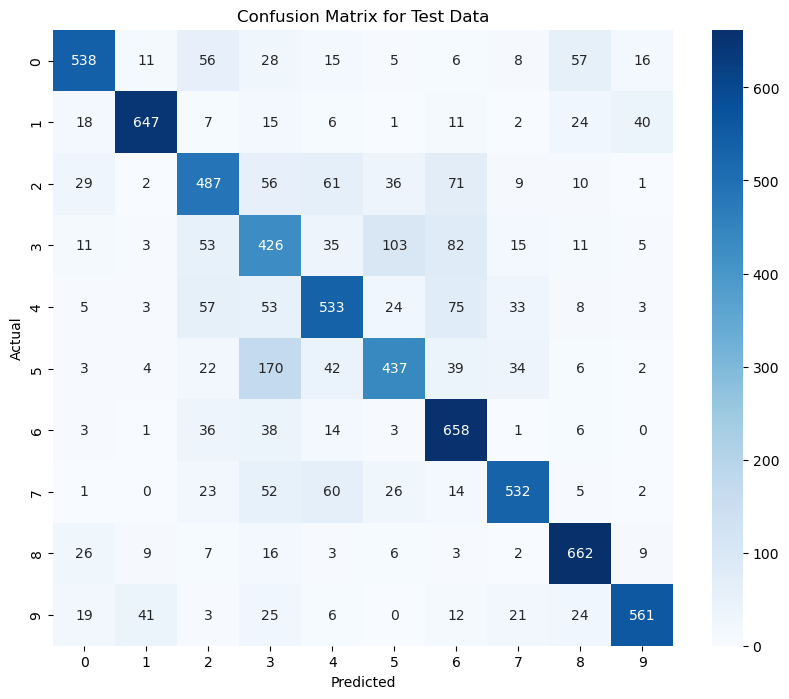

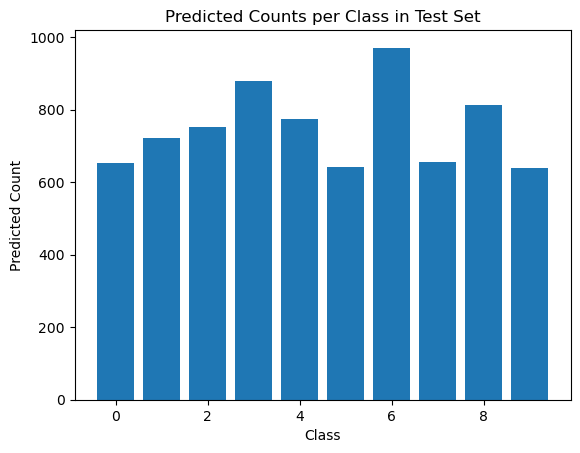

In [12]:
# Example hyperparameter configuration
kernel_size = 3  # or 5
fc_neurons_list = [128, 64]  # List for FC layers
dropout_cnn = 0.2
dropout_fc = 0.5
lr = 0.001
l2 = 0.0001
epochs = 50
patience = 10

# Instantiate and train the model
model = CNN(kernel_size, fc_neurons_list, dropout_cnn, dropout_fc)
train_model(model, train_loader, val_loader, lr, l2, epochs, patience)

# After finding the best model, run on the test set
test_model(model, test_loader)


Epoch 5/50, Train Loss: 2.3239, Val Loss: 2.3043
Epoch 10/50, Train Loss: 2.3039, Val Loss: 2.3042
Early stopping triggered


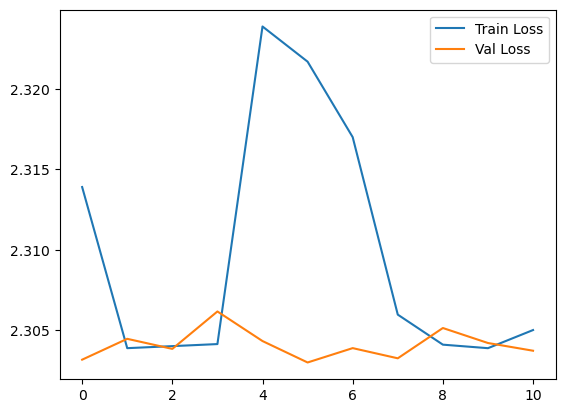

C:\Users\itayg\AppData\Local\Temp\ipykernel_44760\4271745567.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


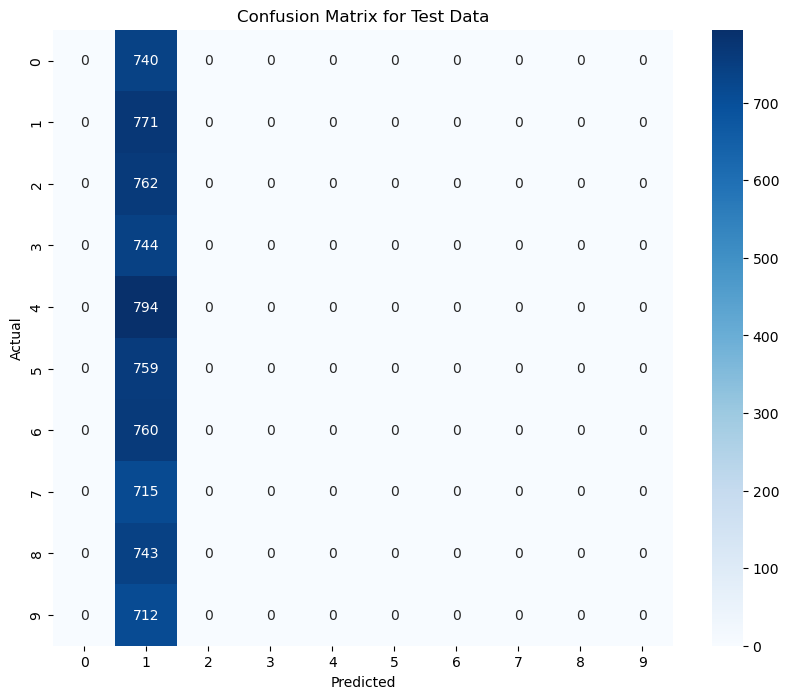

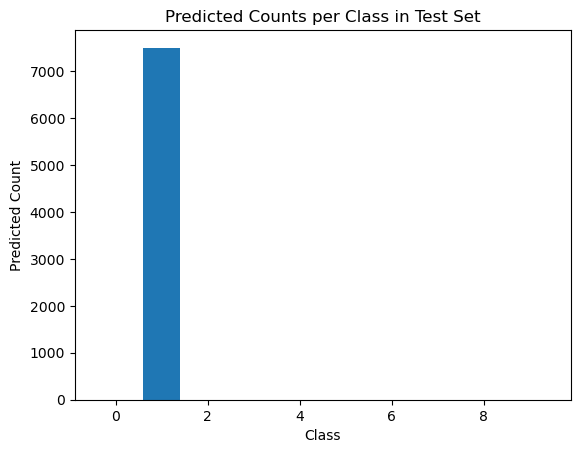

In [17]:
# Example hyperparameter configuration
kernel_size = 3  # or 5
fc_neurons_list = []  # List for FC layers
dropout_cnn = 0.2
dropout_fc = 0.5
lr = 0.01
l2 = 0.0001
epochs = 50
patience = 5

# Instantiate and train the model
model = CNN(kernel_size, fc_neurons_list, dropout_cnn, dropout_fc).to(device)
train_model(model, train_loader, val_loader, lr, l2, epochs, patience)

# After finding the best model, run on the test set
model.load_state_dict(torch.load('best_model.pth'))
test_model(model, test_loader)

Epoch 5/30, Train Loss: 1.2859, Val Loss: 1.3311
Epoch 10/30, Train Loss: 1.1922, Val Loss: 1.2117
Epoch 15/30, Train Loss: 1.1739, Val Loss: 1.2868
Epoch 20/30, Train Loss: 1.1541, Val Loss: 1.2083
Early stopping triggered


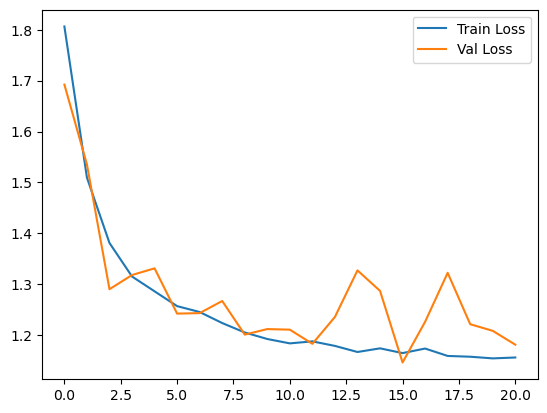

C:\Users\itayg\AppData\Local\Temp\ipykernel_33776\2251995444.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


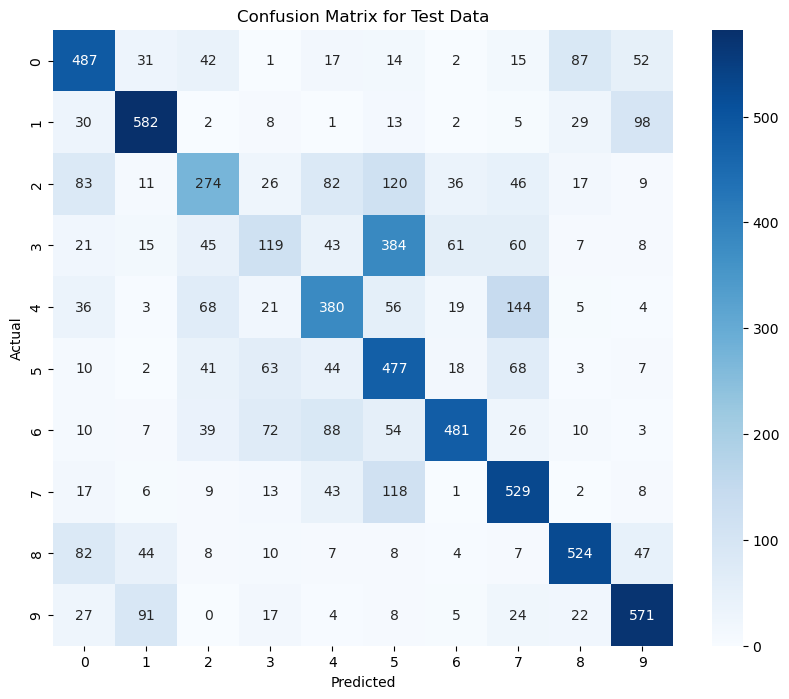

In [29]:
# Example hyperparameter configuration
kernel_size = 3
fc_neurons_list = [128, 64, 22]  # List for FC layers
dropout_cnn = 0.0
dropout_fc = 0.0
lr = 0.001
l2 = 0.001
epochs = 30
patience = 5

# Instantiate and train the model
model = CNN(kernel_size, fc_neurons_list, dropout_cnn, dropout_fc).to(device)
train_model(model, train_loader, val_loader, lr, l2, epochs, patience)

# After finding the best model, run on the test set
model.load_state_dict(torch.load('best_model.pth'))
test_model(model, test_loader)

Epoch 5/30, Train Loss: 0.8096, Val Loss: 0.9489
Epoch 10/30, Train Loss: 0.4095, Val Loss: 0.9556
Epoch 15/30, Train Loss: 0.1657, Val Loss: 1.4092
Early stopping triggered


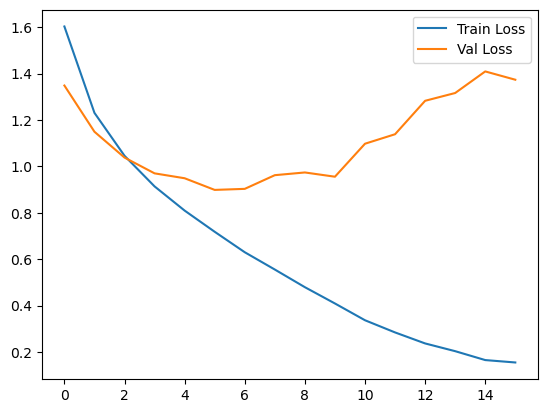

C:\Users\itayg\AppData\Local\Temp\ipykernel_33776\2261306608.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


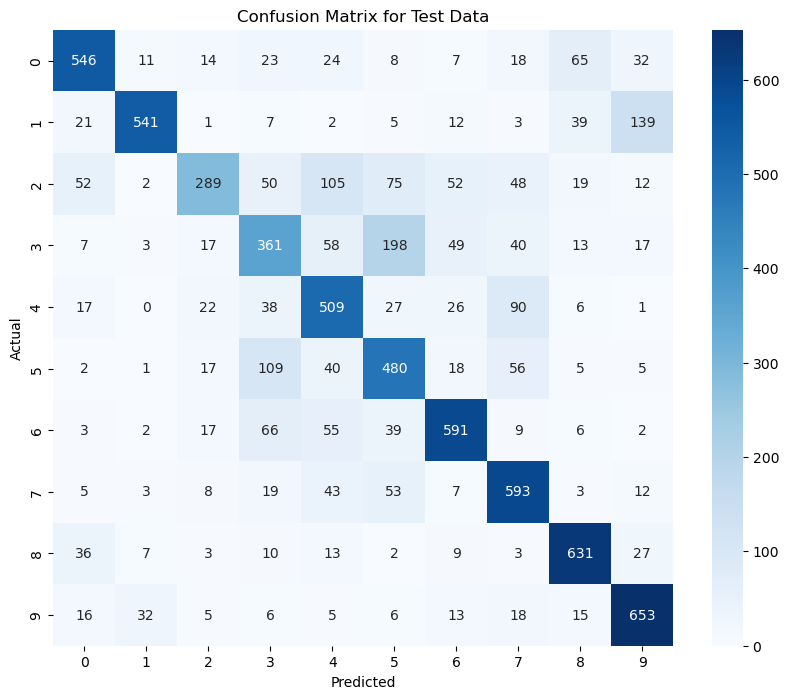

In [31]:
# Example hyperparameter configuration
kernel_size = 3
fc_neurons_list = [128, 64, 22]  # List for FC layers
dropout_cnn = 0.0
dropout_fc = 0.0
lr = 0.001
l2 = 0.0001
epochs = 30
patience = 10

# Instantiate and train the model
model = CNN(kernel_size, fc_neurons_list, dropout_cnn, dropout_fc).to(device)
train_model(model, train_loader, val_loader, lr, l2, epochs, patience)

# After finding the best model, run on the test set
model.load_state_dict(torch.load('best_model.pth'))
test_model(model, test_loader)

Epoch 5/30, Train Loss: 0.8983, Val Loss: 0.9458
Epoch 10/30, Train Loss: 0.5483, Val Loss: 0.9373
Epoch 15/30, Train Loss: 0.2974, Val Loss: 1.0624
Early stopping triggered


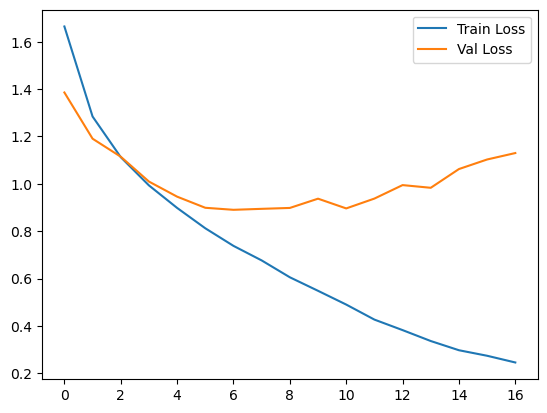

C:\Users\itayg\AppData\Local\Temp\ipykernel_33776\4169889197.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


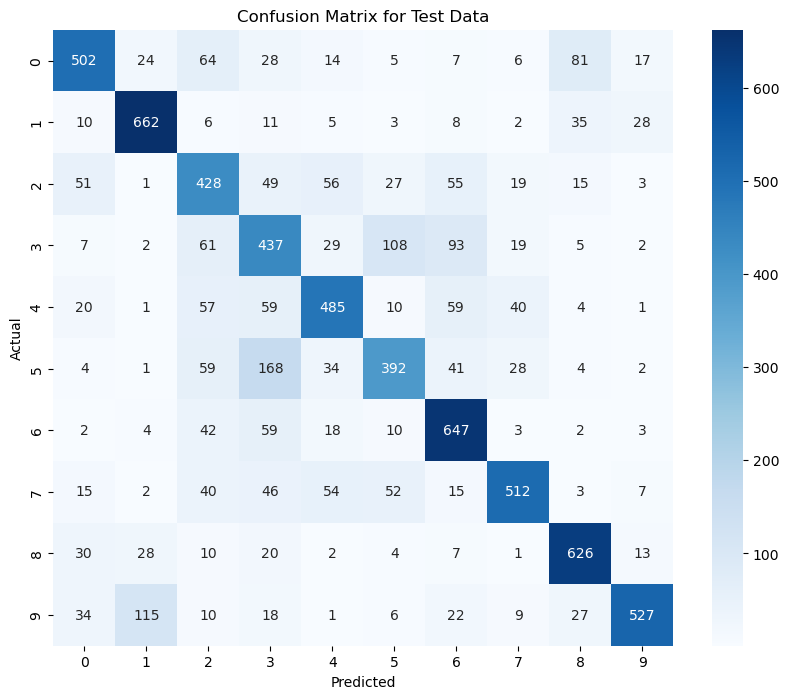

In [32]:
# Example hyperparameter configuration
kernel_size = 3
fc_neurons_list = [128, 64, 22]  # List for FC layers
dropout_cnn = 0.0
dropout_fc = 0.0
lr = 0.001
l2 = 0.001
epochs = 30
patience = 10

# Instantiate and train the model
model = CNN(kernel_size, fc_neurons_list, dropout_cnn, dropout_fc).to(device)
train_model(model, train_loader, val_loader, lr, l2, epochs, patience)

# After finding the best model, run on the test set
model.load_state_dict(torch.load('best_model.pth'))
test_model(model, test_loader)

Epoch 5/30, Train Loss: 0.8521, Val Loss: 0.9351
Epoch 10/30, Train Loss: 0.5726, Val Loss: 0.8908
Epoch 15/30, Train Loss: 0.3544, Val Loss: 0.9826
Early stopping triggered


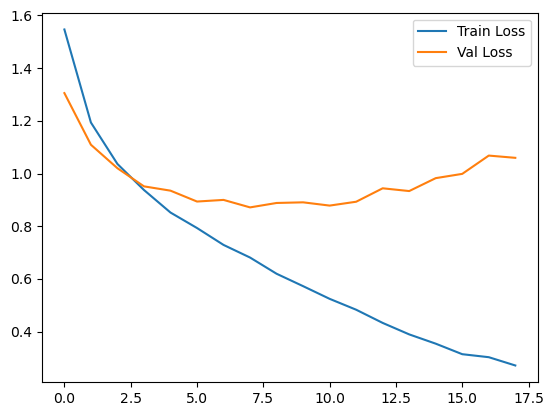

C:\Users\itayg\AppData\Local\Temp\ipykernel_33776\3127381753.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


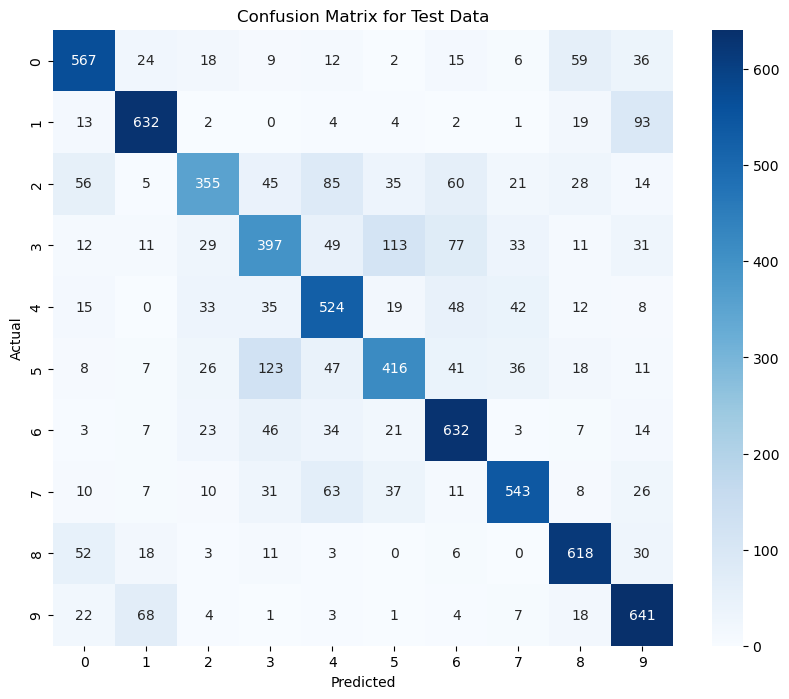

In [33]:
# Example hyperparameter configuration
kernel_size = 3
fc_neurons_list = [128, 22]  # List for FC layers
dropout_cnn = 0.0
dropout_fc = 0.0
lr = 0.001
l2 = 0.001
epochs = 30
patience = 10

# Instantiate and train the model
model = CNN(kernel_size, fc_neurons_list, dropout_cnn, dropout_fc).to(device)
train_model(model, train_loader, val_loader, lr, l2, epochs, patience)

# After finding the best model, run on the test set
model.load_state_dict(torch.load('best_model.pth'))
test_model(model, test_loader)

Epoch 5/50, Train Loss: 0.7319, Val Loss: 0.8870
Epoch 10/50, Train Loss: 0.3103, Val Loss: 1.1396
Epoch 15/50, Train Loss: 0.1201, Val Loss: 1.5833
Early stopping triggered


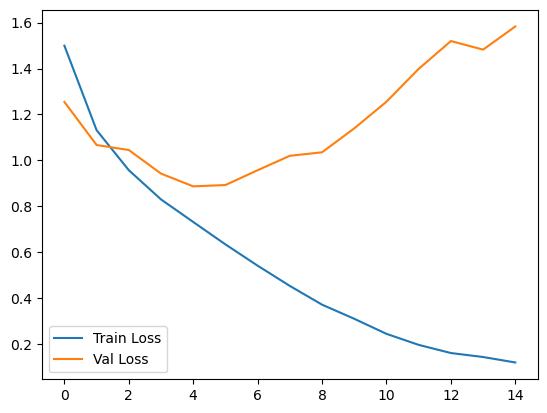

C:\Users\itayg\AppData\Local\Temp\ipykernel_26172\3458820848.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


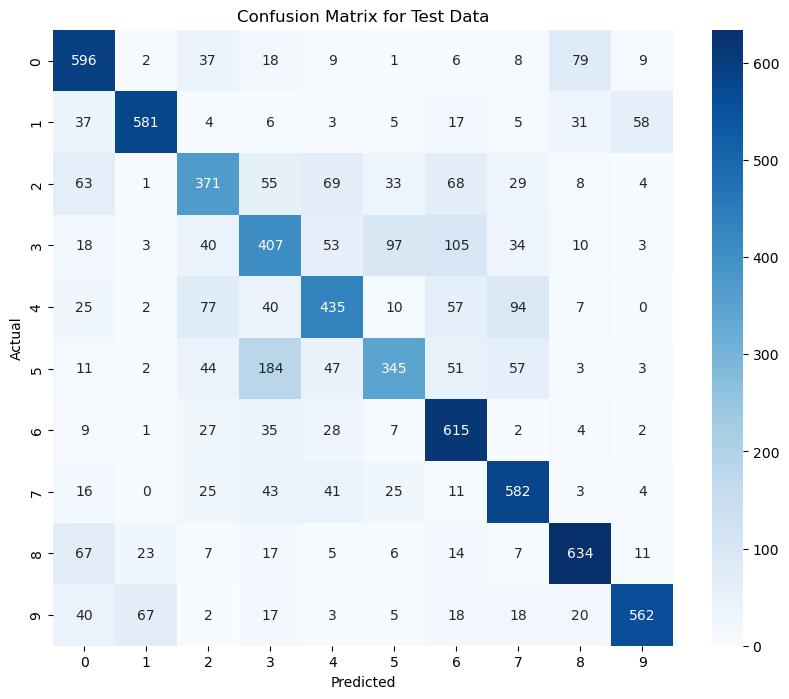

In [7]:
# Example hyperparameter configuration
kernel_size = 3
fc_neurons_list = [128, 64]  # List for FC layers
dropout_cnn = 0.0
dropout_fc = 0.0
lr = 0.001
l2 = 0.0001
epochs = 50
patience = 10

# Instantiate and train the model
model = CNN(kernel_size, fc_neurons_list, dropout_cnn, dropout_fc).to(device)
train_model(model, train_loader, val_loader, lr, l2, epochs, patience)

# After finding the best model, run on the test set
model.load_state_dict(torch.load('best_model.pth'))
test_model(model, test_loader)

In [ ]:
# Example hyperparameter configuration
kernel_size = 3
fc_neurons_list = [128, 64]  # List for FC layers
dropout_cnn = 0.0
dropout_fc = 0.5
lr = 0.001
l2 = 0.001
epochs = 50
patience = 10

# Instantiate and train the model
model = CNN(kernel_size, fc_neurons_list, dropout_cnn, dropout_fc).to(device)
train_model(model, train_loader, val_loader, lr, l2, epochs, patience)

# After finding the best model, run on the test set
model.load_state_dict(torch.load('best_model.pth'))
test_model(model, test_loader)

Epoch 5/50, Train Loss: 1.1829, Val Loss: 1.0434
Epoch 10/50, Train Loss: 1.0004, Val Loss: 0.9222
Epoch 15/50, Train Loss: 0.8937, Val Loss: 0.8742
Epoch 20/50, Train Loss: 0.8175, Val Loss: 0.8509
Epoch 25/50, Train Loss: 0.7611, Val Loss: 0.9153
Epoch 30/50, Train Loss: 0.7234, Val Loss: 0.8528
Epoch 35/50, Train Loss: 0.6835, Val Loss: 0.8651
Epoch 40/50, Train Loss: 0.6542, Val Loss: 0.8443


### testing with 5*5 kernel

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


# CNN model definition
class CNN(nn.Module):
    def __init__(self, kernel_size, fc_layers, dropout_cnn, dropout_fc):
        super(CNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=kernel_size)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate input size for fully connected layers
        self.fc_input_size = self.calculate_fc_input_size()

        # Fully connected layers
        fc_layers_with_input = [self.fc_input_size] + fc_layers + [10]
        self.fc_layers = nn.ModuleList()
        for i in range(len(fc_layers_with_input) - 1):
            self.fc_layers.append(nn.Linear(fc_layers_with_input[i], fc_layers_with_input[i+1]))
            if i < len(fc_layers_with_input) - 2:  # Not the output layer
                self.fc_layers.append(nn.ReLU())
                self.fc_layers.append(nn.Dropout(dropout_fc))

    def calculate_fc_input_size(self):
        # Determine the input size for the fully connected layers
        x = torch.randn(1, 3, 32, 32)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x.view(-1).shape[0]

    def forward(self, x):
        # Forward pass through the convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten and pass through fully connected layers
        x = x.view(-1, self.fc_input_size)  # flatten
        for layer in self.fc_layers:
            x = layer(x)
        return x

# Training function
# Training function with Loss Plot
def train_model(model, train_loader, val_loader, epochs, patience):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    best_val_loss = np.inf
    best_epoch = 0
    patience_counter = 0
    val_losses = []
    train_losses = []  # Store train losses for plotting
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Append train loss
        
        # Validate on the validation set
        val_loss = evaluate_model(model, val_loader)
        val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')

    print(f'Best Val Loss: {best_val_loss:.4f} at epoch {best_epoch + 1}')
    
    # Plot Train Loss and Val Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.show()

    return model

# Validation and evaluation function
def evaluate_model(model, loader):
    model.eval()
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(loader)

# Testing function with Confusion Matrix
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    
    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}')
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    




In [18]:
# Hyperparameters (adjustable)
kernel_size = 5
fc_layers = [128,64, 32]
dropout_cnn = 0.0
dropout_fc = 0.0
learning_rate = 0.001
weight_decay = 0.001
epochs = 50
patience = 10
batch_size = 30
# Initialize the model
model = CNN(kernel_size=kernel_size, fc_layers=fc_layers, dropout_cnn=dropout_cnn, dropout_fc=dropout_fc)

# Train the model
trained_model = train_model(model, train_loader, val_loader, epochs, patience)

# Evaluate the model on the test set
test_model(trained_model, test_loader)


Epoch [1/50], Train Loss: 1.6914, Val Loss: 1.4570
Epoch [2/50], Train Loss: 1.3361, Val Loss: 1.2558
Epoch [3/50], Train Loss: 1.1649, Val Loss: 1.1824
Epoch [4/50], Train Loss: 1.0364, Val Loss: 1.0527
Epoch [5/50], Train Loss: 0.9454, Val Loss: 1.0121
Epoch [6/50], Train Loss: 0.8721, Val Loss: 0.9576
Epoch [7/50], Train Loss: 0.8011, Val Loss: 0.9426
Epoch [8/50], Train Loss: 0.7443, Val Loss: 0.9329
Epoch [9/50], Train Loss: 0.6970, Val Loss: 0.9144
Epoch [10/50], Train Loss: 0.6481, Val Loss: 0.9438
Epoch [11/50], Train Loss: 0.6078, Val Loss: 0.9290
Epoch [12/50], Train Loss: 0.5651, Val Loss: 0.9539
Epoch [13/50], Train Loss: 0.5256, Val Loss: 0.9315
Epoch [14/50], Train Loss: 0.4934, Val Loss: 0.9582
Epoch [15/50], Train Loss: 0.4585, Val Loss: 0.9865


KeyboardInterrupt: 

Epoch [1/50], Train Loss: 1.8176, Val Loss: 1.6763
Epoch [2/50], Train Loss: 1.5921, Val Loss: 1.6056
Epoch [3/50], Train Loss: 1.5240, Val Loss: 1.4770
Epoch [4/50], Train Loss: 1.4614, Val Loss: 1.4418
Epoch [5/50], Train Loss: 1.4211, Val Loss: 1.5144
Epoch [6/50], Train Loss: 1.3962, Val Loss: 1.4040
Epoch [7/50], Train Loss: 1.3787, Val Loss: 1.4584
Epoch [8/50], Train Loss: 1.3561, Val Loss: 1.3449
Epoch [9/50], Train Loss: 1.3411, Val Loss: 1.4248
Epoch [10/50], Train Loss: 1.3436, Val Loss: 1.4043
Epoch [11/50], Train Loss: 1.3109, Val Loss: 1.3345
Epoch [12/50], Train Loss: 1.3158, Val Loss: 1.3964
Epoch [13/50], Train Loss: 1.3011, Val Loss: 1.2948
Epoch [14/50], Train Loss: 1.2854, Val Loss: 1.3761
Epoch [15/50], Train Loss: 1.3022, Val Loss: 1.3376
Epoch [16/50], Train Loss: 1.2680, Val Loss: 1.3040
Epoch [17/50], Train Loss: 1.2668, Val Loss: 1.4467
Early stopping at epoch 18
Best Val Loss: 1.2948 at epoch 13


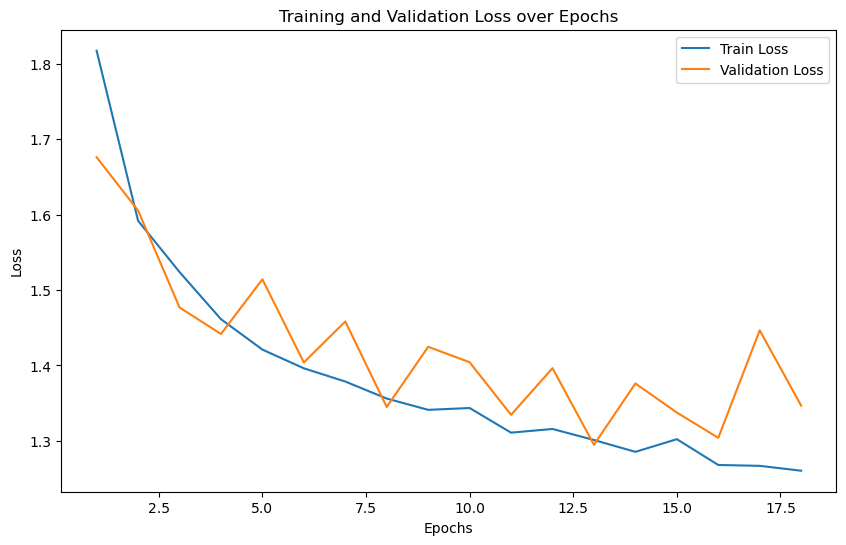

Test Loss: 1.3111, Test Accuracy: 0.5381


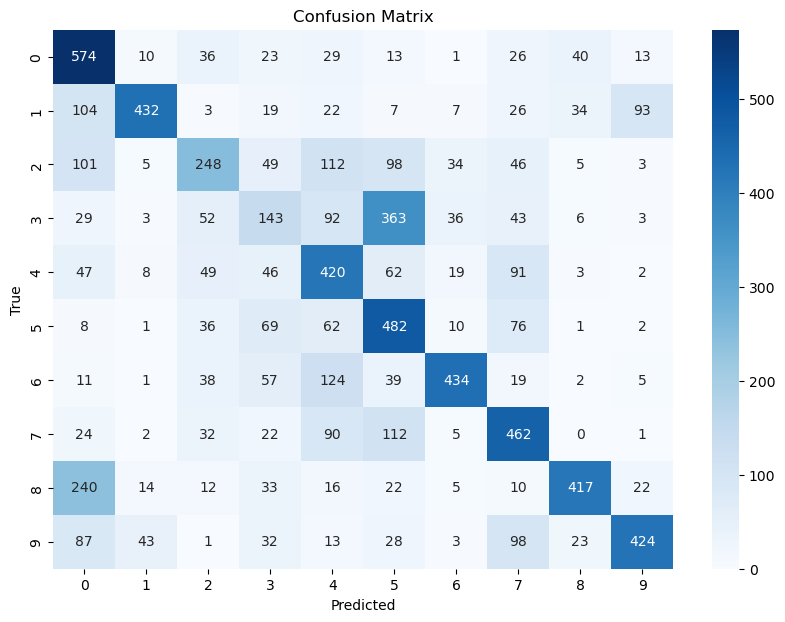

In [16]:
# Hyperparameters (adjustable)
kernel_size = 5
fc_layers = [128,64]
dropout_cnn = 0.0
dropout_fc = 0.0
learning_rate = 0.01
weight_decay = 0.001
epochs = 50
patience = 5
batch_size = 64
# Initialize the model
model = CNN(kernel_size=kernel_size, fc_layers=fc_layers, dropout_cnn=dropout_cnn, dropout_fc=dropout_fc)

# Train the model
trained_model = train_model(model, train_loader, val_loader, epochs, patience)

# Evaluate the model on the test set
test_model(trained_model, test_loader)


Epoch [1/50], Train Loss: 1.5794, Val Loss: 1.3423
Epoch [2/50], Train Loss: 1.2041, Val Loss: 1.1526
Epoch [3/50], Train Loss: 1.0278, Val Loss: 1.0515
Epoch [4/50], Train Loss: 0.9173, Val Loss: 0.9619
Epoch [5/50], Train Loss: 0.8170, Val Loss: 0.9965
Epoch [6/50], Train Loss: 0.7415, Val Loss: 0.9197
Epoch [7/50], Train Loss: 0.6665, Val Loss: 0.9255
Epoch [8/50], Train Loss: 0.6051, Val Loss: 0.9950
Epoch [9/50], Train Loss: 0.5369, Val Loss: 0.9504
Epoch [10/50], Train Loss: 0.4702, Val Loss: 0.9792
Early stopping at epoch 11
Best Val Loss: 0.9197 at epoch 6


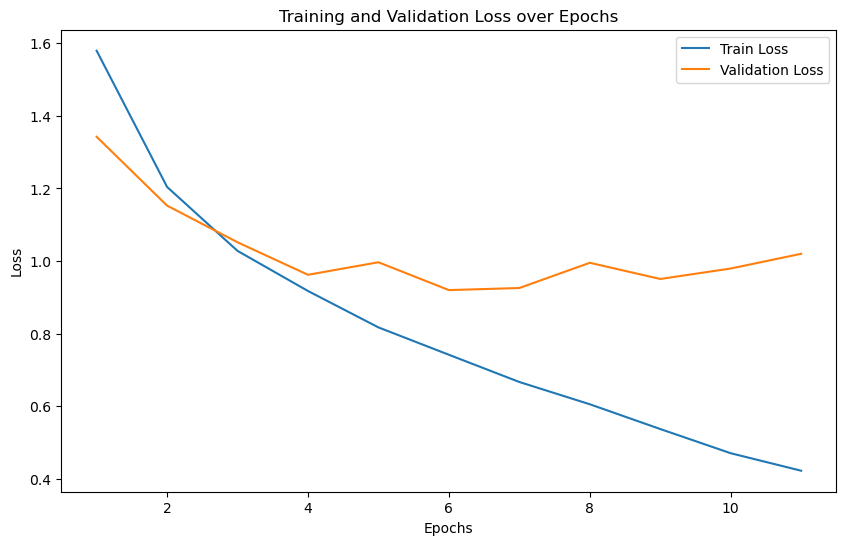

Test Loss: 0.9670, Test Accuracy: 0.7017


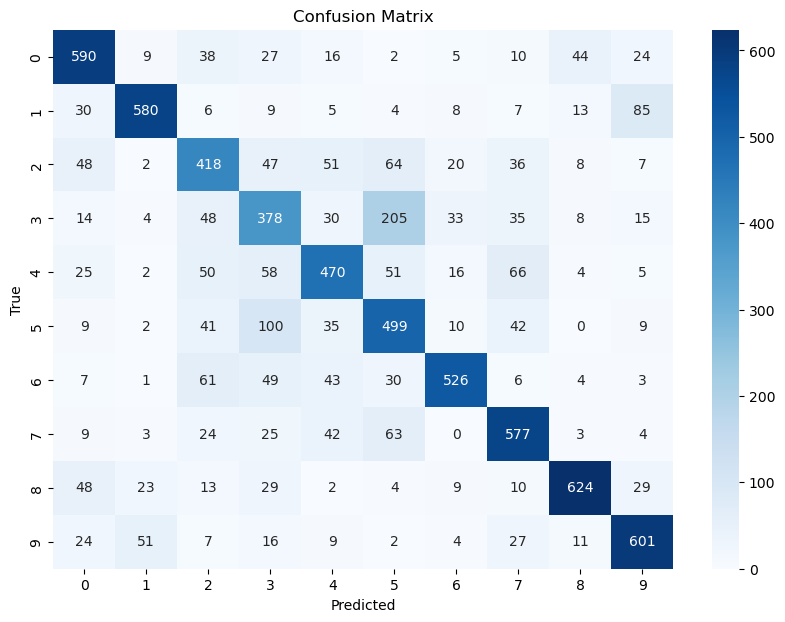

In [17]:
# Hyperparameters (adjustable)
kernel_size = 5
fc_layers = [128,64]
dropout_cnn = 0.0
dropout_fc = 0.0
learning_rate = 0.001
weight_decay = 0.0001
epochs = 50
patience = 5
batch_size = 64
# Initialize the model
model = CNN(kernel_size=kernel_size, fc_layers=fc_layers, dropout_cnn=dropout_cnn, dropout_fc=dropout_fc)

# Train the model
trained_model = train_model(model, train_loader, val_loader, epochs, patience)

# Evaluate the model on the test set
test_model(trained_model, test_loader)


Epoch [1/50], Train Loss: 1.6184, Val Loss: 1.3271
Epoch [2/50], Train Loss: 1.2455, Val Loss: 1.1380
Epoch [3/50], Train Loss: 1.0773, Val Loss: 1.0375
Epoch [4/50], Train Loss: 0.9586, Val Loss: 0.9754
Epoch [5/50], Train Loss: 0.8493, Val Loss: 0.9337
Epoch [6/50], Train Loss: 0.7759, Val Loss: 0.9303
Epoch [7/50], Train Loss: 0.6982, Val Loss: 0.8979
Epoch [8/50], Train Loss: 0.6396, Val Loss: 0.8816
Epoch [9/50], Train Loss: 0.5771, Val Loss: 0.8943
Epoch [10/50], Train Loss: 0.5288, Val Loss: 0.9099
Epoch [11/50], Train Loss: 0.4895, Val Loss: 0.9375
Epoch [12/50], Train Loss: 0.4405, Val Loss: 0.9753
Early stopping at epoch 13
Best Val Loss: 0.8816 at epoch 8


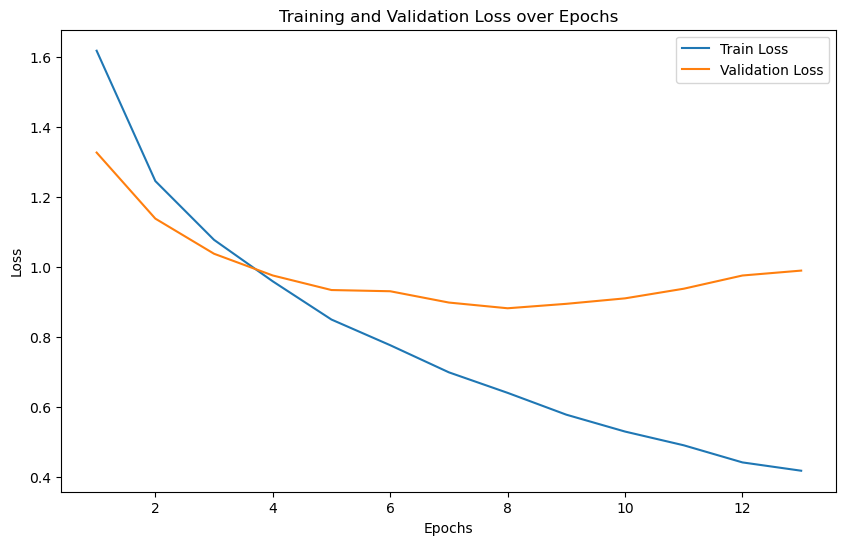

Test Loss: 0.9113, Test Accuracy: 0.7249


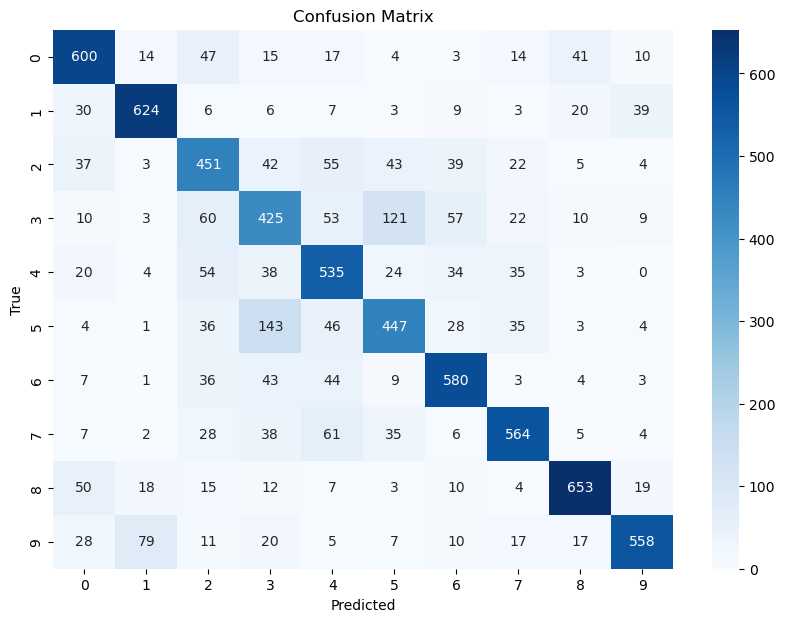

In [21]:
# Hyperparameters (adjustable)
kernel_size = 3
fc_layers = [512,256]
dropout_cnn = 0.2
dropout_fc = 0.4
learning_rate = 0.001
weight_decay = 0.0001
epochs = 50
patience = 5
batch_size = 64
# Initialize the model
model = CNN(kernel_size=kernel_size, fc_layers=fc_layers, dropout_cnn=dropout_cnn, dropout_fc=dropout_fc)

# Train the model
trained_model = train_model(model, train_loader, val_loader, epochs, patience)

# Evaluate the model on the test set
test_model(trained_model, test_loader)


In [ ]:
# Hyperparameters (adjustable)
kernel_size = 3
fc_layers = [512,256,128,64,32]
dropout_cnn = 0.2
dropout_fc = 0.4
learning_rate = 0.001
weight_decay = 0.0001
epochs = 50
patience = 5
batch_size = 64
# Initialize the model
model = CNN(kernel_size=kernel_size, fc_layers=fc_layers, dropout_cnn=dropout_cnn, dropout_fc=dropout_fc)

# Train the model
trained_model = train_model(model, train_loader, val_loader, epochs, patience)

# Evaluate the model on the test set
test_model(trained_model, test_loader)
